In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

% matplotlib inline

In [85]:
def defineAnnuli(r,nAnn):
    return np.append(0.,np.sort(r)[np.linspace(0,len(r)-1,nAnn).astype(int)][1:])

def labelGalaxies(data,annuli):
    #adds a column to data indicating the galaxy's membership in an annulus
    bla = np.zeros(len(data['r']))
    for i in range(len(annuli)-1):
        bla += i*np.array(np.logical_and(data['r']>annuli[i],data['r']<=annuli[i+1]).astype(int))
    return bla

def galInAnn(data,annuli):
    #calculates the number of galaxies in all the annuli
    return np.array([(data['annuli']==i).sum() for i in range(len(annuli)-1)])

def sigInAnn(data,annuli):
    return [np.std(data['vobs'][data['annuli']==i],ddof=1) for i in range(len(annuli)-1)]



In [86]:
data=pd.read_csv('mock_cluster_4.csv')
data.rename(columns={'Unnamed: 0':'id','0':'origAnn','1':'x','2':'y','3':'z','4':'vobs'},inplace=True)

data['r'] = np.power(np.power(data['x'],2.)+np.power(data['y'],2.),0.5)

nAnn = 10 #number of desired annuli
annuli = defineAnnuli(data['r'],nAnn+1) 

print annuli

#summarize the true data

# number of galaxies per annulus
    
data['annuli']=labelGalaxies(data,annuli)
nData = galInAnn(data,annuli)
sigmaData = sigInAnn(data,annuli)

print nData
print sigmaData

[   0.            2.16977251    5.10062805   11.24012234   23.85469564
   47.14815397   81.82870312  160.69250602  272.81301104  513.90598477
  982.44091053]
[100 100 100 100 100 100 100 100 100 100]
[455.7315393340661, 369.35057741152025, 363.57837953021146, 349.1132399792908, 291.58460160645734, 239.9344549352395, 203.8709882735333, 198.55328902678087, 156.91619386615668, 163.1204445996056]


In [97]:
def defineShellRadii(nTot=1000.,rOut=1000.,nAnn=10,k=3):
    radii = np.array([1.])
    if k==3.:
        nu0 = nTot/(4*np.pi*np.log(rOut))
        c = nTot/(nAnn*4*np.pi*nu0)
    else:
        nu0 = nTot*(3.-k)/(4*np.pi*(rOut**(3.-k)-1.))
        c = (3-k)*nTot/(4*np.pi*nu0*nAnn)
        
    for i in range(nAnn):
        if k==3.:
            radii = np.append(radii,np.exp(c+np.log(radii[i])))
        else:
            radii = np.append(radii,(c+radii[i]**(3-k))**(1./(3-k)))
    return radii

defineShellRadii()

def nuProfile(Ntot,radii,k=2.9):
    nu0 = Ntot / (4.*np.pi*(nuInt(radii[-1], k)-nuInt(radii[0], k)))
    print nu0
    #print 'nu0:' ,nu0
    return (nu0*(nuInt(radii[1:],k) - nuInt(radii[:-1],k))).astype(int)

def sigmaProfile(radii,sigMax=1000,k=-.2):
    return sigMax*(0.5*(radii[1:]+radii[:-1]))**k

In [98]:
def createMockData(Ntot=1000,rOut=1000.,nAnn=10,sigMax=1000,kindex=3.,sigmaindex=-0.2): #total Ngals, no of shells
    clusterData = np.zeros((2*Ntot,2))
    counter=0
    radii = defineShellRadii(Ntot,rOut,nAnn,kindex)
    #density = nuProfile(Ntot,radii,k=kindex)
    sig = sigmaProfile(radii,sigMax,k=sigmaindex)
    
    for shell,dens in enumerate(np.random.poisson(Ntot/nAnn*np.ones(nAnn))):
        #generate positions
        phi = np.random.uniform(0.,2*np.pi,dens)
        cosTheta = np.random.uniform(-1,1,dens)
        theta = np.arccos(cosTheta)
        u = np.random.uniform(radii[shell]**3,radii[shell+1]**3,dens) #cuberoot([rin,rout])
        r = np.power(u,1./3)
        
        x = r*np.sin(theta)*np.cos(phi)
        y = r*np.sin(theta)*np.sin(phi)
        z = r*cosTheta
        
        radius = np.power(np.power(x,2.)+np.power(y,2.),0.5)
        #generate velocities
        
        speed = sig[shell]*np.random.randn(dens)
        #phi = np.random.uniform(0.,2*np.pi,dens)
        cosTheta = np.random.uniform(-1,1,dens)
        #theta = np.arccos(cosTheta)
        
        v=speed*cosTheta
        
        #replace with vstack,append
        clusterData[counter:counter+dens]=np.hstack((radius.reshape((dens,1)),v.reshape((dens,1))))
        counter += dens
    
    #print 'Created mock data with '+str(counter)+' galaxies.'
    return pd.DataFrame(clusterData[:counter],columns=['r','vobs'])

In [99]:
#a single "mcmc step"
kIndex = 3
sigmaIndex = -0.2
sigMax = 1000

def mcmcStep(annuli,kInd,sInd,sMaxInd):
    mockData = createMockData(len(data['r']),np.amax(data['r']),10,sigMax,kIndex,sigmaIndex)
    mockData['annuli'] = labelGalaxies(mockData,annuli)
    return galInAnn(mockData,annuli),sigInAnn(mockData,annuli)

print mcmcStep(annuli,kIndex,sigmaIndex,sigMax)

(array([119, 132, 117, 128, 116,  74,  99,  81,  96,  74]), [447.8556244339395, 401.7022350362943, 355.5429756941821, 300.3772727017605, 240.5778413788299, 222.57007234316853, 209.68888176408697, 168.87427747372982, 157.9790986146449, 164.67398672615434])


In [100]:
#all log likelihoods

def logPriorNu():
    return 0.0

def logPriorSigma():
    return 0.0

def logLikelihoodNu(prediction,data):
    return np.sum(data*np.log(prediction)-prediction)

def logLikelihoodSigma(vObs,vPred,nPred):
    # distribution of variances is chisq, as shown, for example, at
    # https://onlinecourses.science.psu.edu/stat414/node/174
    return np.sum(np.log(stats.chi2.pdf((nPred-1.)*np.power(vObs,2.)/np.power(vPred,2.),nPred-1)))

In [ ]:
nRuns = 10000
burn=1000

chain = []
probs = []
naccept = 0
    
print 'Running MC for', nRuns, 'steps'


nOld,sigmaOld = mcmcStep(annuli,kIndex,sigmaIndex,sigMax)
lOld = logPriorNu()+logPriorSigma()+logLikelihoodNu(nOld,nData)+logLikelihoodSigma(sigmaData,sigmaOld,nOld)

kOld = kIndex
sIndOld = sigmaIndex
sMaxOld = sigMax

for i in range(burn+nRuns):
    if i%50==0: 
        print 'Iteration '+str(i)+'/'+str(burn+nRuns)
    kNew = kOld+0.01*np.random.randn()
    sIndNew = sIndOld+0.01*np.random.randn()
    sMaxNew = sMaxOld+10*np.random.randn()
    nMock,sigmaMock = mcmcStep(annuli,kNew,sIndNew,sMaxNew)
    lNew=logPriorNu()+logPriorSigma()+logLikelihoodNu(nMock,nData)+logLikelihoodSigma(sigmaData,sigmaMock,nMock)
    
    if (np.exp(lNew - lOld) > np.random.uniform()):
        # accept
        kOld = kNew
        sIndOld = sIndNew
        sMaxOld = sMaxNew
        lOld = lNew
        if (i > burn): #measure acceptance rate after burn-in only
            naccept += 1
    else:
        # Stay where we are; m,b stay the same, and we append them
        # to the chain below.
        pass

    chain.append((kOld,sIndOld,sMaxOld))

print 'Acceptance fraction:', naccept/float(nRuns)
#return chain[burn_in:]
    

Running MC for 10000 steps
Iteration 0/11000
Iteration 50/11000
Iteration 100/11000
Iteration 150/11000
Iteration 200/11000
Iteration 250/11000
Iteration 300/11000
Iteration 350/11000
Iteration 400/11000
Iteration 450/11000
Iteration 500/11000
Iteration 550/11000
Iteration 600/11000
Iteration 650/11000
Iteration 700/11000
Iteration 750/11000
Iteration 800/11000
Iteration 850/11000
Iteration 900/11000
Iteration 950/11000
Iteration 1000/11000
Iteration 1050/11000
Iteration 1100/11000
Iteration 1150/11000
Iteration 1200/11000
Iteration 1250/11000
Iteration 1300/11000
Iteration 1350/11000
Iteration 1400/11000
Iteration 1450/11000
Iteration 1500/11000
Iteration 1550/11000
Iteration 1600/11000
Iteration 1650/11000
Iteration 1700/11000
Iteration 1750/11000
Iteration 1800/11000
Iteration 1850/11000
Iteration 1900/11000
Iteration 1950/11000
Iteration 2000/11000
Iteration 2050/11000
Iteration 2100/11000
Iteration 2150/11000
Iteration 2200/11000
Iteration 2250/11000
Iteration 2300/11000
Iteration

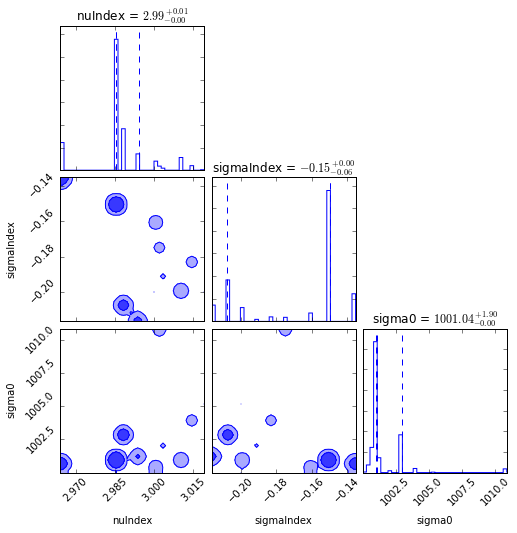

In [102]:
import corner
corner.corner(chain, labels=['nuIndex','sigmaIndex','sigma0'],quantiles=[0.16,0.5,0.84],
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=True, fill_contours=True, levels=[0.68, 0.95], color='b', bins=40, smooth=1.0);
plt.show()